# Supporting Information: Climate Implications of CCS Implementation Timing and Natural Gas Methane Emission Uncertainty

Greg Schivley, Paulina Jaramillo, Constantine Samaras*

*csamaras@cmu.edu


## Description

This IPython Notebook presents code and data used to calculate emissions for supercritical pulvarized coal (SCPC) and natural gas combined cycle (NGCC) power plants that begin operations with, or transition to, carbon capture and storage (CCS). We also examine the uncertainty of current methane emissions from natural gas systems, and what will happen if those emissions are reduced.

In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from ghgforcing import CO2, CH4
# import cPickle as pickle
# import gzip
import os
from os.path import join
import re

## Background Data

### Coal Extraction Emissions

GHG emissions for underground bituminous coal extraction are from the 2014 NETL report *Life Cycle Analysis of Natural Gas Extraction and Power Generation* [(1)](#References). They are 2.69E-2 kg CO<sub>2</sub> and 3.32E-3 kg CH<sub>4</sub> per kg of coal.

### Natural Gas Extraction and Transmission Emissions

Methane emissions in the model are varied parametrically with the leakage rate. For every percent leakage, 1 kg of methane is emitted per 100 kg natural gas delivered. While CO2 emissions may vary with the methane leakage rate, we assume that they are fixed value equal to the 3.8 g/MJ reported by NETL in 2016 [(2)](#References).

### Defining Emissions

Our goal is to examine implications of building natural gas plants now rather than coal if advanced coal with CCS might have lower climate impacts than NGCC w/CCS when methane emission rates are above a certain amount.

We start with new plants of each type and examine the following scenarios:

- Fixed methane emission rates from natural gas varied from 1-5%. CCS with 90% capture is included at the start of operations or added after 20 years.
- Emission rates decrease over time, starting at 1-5% and going down to half of the initial rate (minimum of 1%). CCS with 90% capture is included at the start of operations or added after 20 years.
- CCS at 90% capture for the SCPC, but no CCS for the NGCC. Natural gas methane emissions are reduced over time, as above.
- CCS at 16% capture for the SCPC, to match EPA Carbon Pollution Standards limit of 1,400 lb CO<sub>2</sub>/MWh gross. No CCS for the NGCC, both constant and reduced methane emissions.

### Emissions and feedstock value from the 2015 NETL baseline report [(3)](#References):

- SCPC w/o CCS: 773.6 kg CO2/MWh net, 325.8 kg coal/MWh net
    - A plant at 8,379 btu/kWh burning bit coal
- SCPC w 90% CCS: 97.0 kg CO2/MWh net, 408.6 kg coal/MWh net
    - Heat rate of 10,508 btu/kWh. 90% capture on a plant that starts at 8,379 btu/kWh
- SCPC w CCS (82.2% bypass): 682.1 kg CO2/MWh net, 342.0 kg coal/MWh net 
    - **Calculated in PPFM [(4)](#References) starting with no capture and then adding CCS with 82.2% bypass**
    - Heat rate of 8,795 btu/kWh. Approx. 16% capture on a plant that starts at 8,379 btu/kWh
- NGCC w/o CCS: 353.2 kg CO2/MWh net, 133.4 kg NG/MWh net
    - A plant at 6,629 btu/kWh burning natural gas
- NGCC w 90% CCS: 39.8 kg CO2/MWh net, 150.2 kg NG/MWh net
    - Heat rate of 7,466 btu/kWh. 90% capture on a plant that starts at 6,629 btu/kWh

In the code below:

- Time frame under examination is 100 years, with 0.01 year timesteps
- Power plants operate for 60 years
- CCS is implemented after an amount of time defined by *CCS_start*

In [2]:
size = 1000 # MW
hours = 365 * 24
capacity_factor = 0.8

generation = size * hours * capacity_factor #MWh/yr

end = 100
tstep = 0.01
time = np.linspace(0, end, num=int(end/tstep+1)) #time array
life = 40

## Define emissions

### Natural Gas

In [3]:
# Hardcoded/calculated emission values for natural gas and NGCC plants
Mbtu_to_MJ = 1.05506 # MJ per Mbtu, used for heat rate conversion
ngcc_ng = 133.4 #kg NG for 1MWh NGCC w/o CCS from PPFM (uses NG energy content of 52.43 MJ/kg)
ngcc_ccs_ng = 150.2 #kg NG for 1MWh NGCC w CCS from PPFM (uses NG energy content of 52.43 MJ/kg)
ngcc_MJ = 6629 * Mbtu_to_MJ # Convert btu/kWh heat rate to MJ/MWh
ngcc_ccs_MJ = 7466 * Mbtu_to_MJ # Convert btu/kWh heat rate to MJ/MWh
CH4_per_kg_leak = 0.01 #kg methane per % emission per kg NG
CO2_per_MJ = 3.8 / 1000 #kg CO2 per % emission per MJ NG

CH4_per_leak =  ngcc_ng * CH4_per_kg_leak
CH4_per_leak_CCS = ngcc_ccs_ng * CH4_per_kg_leak
base_CO2 = 357 + CO2_per_MJ * ngcc_MJ # From Exhibit 4-8 of Ref. 3
base_CO2_CCS = 40 + CO2_per_MJ * ngcc_ccs_MJ # From Exhibit 4-22 of Ref. 3

# Dictionary of emission values for NGCC power plants
# Leak emissions are per percent leakage rate
ng_emissions = {'0%': {'Fixed': {'CO2': base_CO2,
                                   'CH4': 0},
                           'Leak': {'CO2': 0,
                                   'CH4': CH4_per_leak}
                         },
                 '90%': {'Fixed': {'CO2': base_CO2_CCS,
                                   'CH4': 0},
                           'Leak': {'CO2': 0,
                                   'CH4': CH4_per_leak_CCS}
                         }
               }

### Coal
All coal feedstock and emission values that are calculated using the public NETL PPFM tool [(4)](#References) required the following adjustments to the tool, which uses parameters from a previous version of the NETL Cost and Performance Baseline report [(3)](#References):
- Change the CO<sub>2</sub> compressor load factor (cell EX126 on the "Flow_Chart" sheet) to 11.77 kW/m<sup>3</sup>/s
- Change the heat rate for Case 11 (SCPC w/o CCS) to 8,379 btu/kWh
- Change the heat rate for Case 12 (SCPC w/ CCS) to 10,508 btu/kWh

All values for the 111(b) scenario are calculated in PPFM using the following steps:
- Start with Case 11 (SCPC w/o CCS)
- Adjust the heat rate to 8,379 btu/kWh
- Add CCS (cell B24 on the "Summary_Sheet")
- Adjust the Capture bypass (cell B26) to 82.2%

In [4]:
# Hardcoded/calculated emission values for coal and SCPC plants
coal_co2 = 3.75E-2 #kg co2 per kg I6 coal from NETL 2014 NG report
coal_ch4 = 7.64E-03 #kg ch4 per kg I6 coal from NETL 2014 NG report
scpc_coal = 325.8 #kg coal for 1MWh SCPC w/o CCS from PPFM with heat rate of 8379 btu/kWh
scpc_direct_co2 = 773.7 #kg co2 from 1MWh SCPC w/o CCS from PPFM with heat rate of 8379 btu/kWh
scpc_co2 = scpc_direct_co2 + (scpc_coal * coal_co2)
scpc_ch4 = scpc_coal * coal_ch4


scpc_ccs_coal = 408.6 #kg coal for 1MWh SCPC w/ CCS from PPFM with heat rate of 10508 btu/kWh
scpc_ccs_co2 = 97 #kg co2 from 1MWh SCPC w/ CCS from PPFM with heat rate of 10508 btu/kWh
scpc_ccs_co2_product = 873.1 #kg co2 product from 1MWh SCPC w/ CCS from PPFM
scpc_ccs_co2 = scpc_ccs_co2 + (scpc_ccs_coal * coal_co2)
scpc_ccs_ch4 = scpc_ccs_coal * coal_ch4

# All 111b values are based on emissions of 1,400 lb/MWh gross from final EPA 111(b) rule
scpc_111b_coal = 342.1 #kg coal for 1MWh SCPC w/ CCS from PPFM
scpc_111b_co2 = 682.2 #kg co2 from 1MWh SCPC w/ CCS from PPFM
scpc_111b_co2_product = 122 #kg co2 product from 1MWh SCPC w/ CCS from PPFM
scpc_111b_co2 = scpc_111b_co2 + (scpc_111b_coal * coal_co2)
scpc_111b_ch4 = scpc_111b_coal * coal_ch4

# Dictionary of emission values for NGCC power plants
coal_emissions = {'90%': {'CO2':scpc_ccs_co2,
                          'CH4': scpc_ccs_ch4},
                  '0%': {'CO2':scpc_co2,
                          'CH4':scpc_ch4},
                  '16%':{'CO2':scpc_111b_co2,
                          'CH4': scpc_111b_ch4}
                 }

In [5]:
def emissions(coal_emissions=coal_emissions, ng_emissions=ng_emissions,
              CCS_start=0, leakage_drop_by=10,
              leak_values=range(1,6), year_to_90CSS=20, life=40):
    """
    Create CO2 and CH4 emission functions for each power plant scenario. All
    natural gas scenarios include both constant leakage rates and leakage rates
    that are reduced by half over time.

    inputs:
        coal_emissions: dict
            Dictionary of CO2 and CH4 emission values for each CCS capture rate
        ng_emissions: dict
            Dictionary of CO2 and CH4 emission values for each CCS capture rate
            with additional keys for fixed values and values that vary by leakage
        CCS_start: int
            Year of operation that CCS begins
        leakage_drop_by: int
            Year of operation where methane emissions have dropped
            by half of initial value.
        leak_values: list or other iterable
            Numeric values representing leakage rate scenarios. 1 = 1%, etc.
        year_to_90CCS: int
            If coal CCS starts at 111b levels (16%), this is the year where it
            changes to 90% capture.
        life: int
            Lifetime of the power plants
    outputs:
        emissions_df: dataframe
            A single tidy dataframe with all emission scenarios
        df_list: list of dataframes
            A list with individual dataframes for each specific emission scenario
    """
    end = 100
    tstep = 0.01
    time = np.linspace(0, end, num=int(end/tstep+1)) #time array


    leak = {} # dictionary of leak values
    for value in leak_values:
        # Change values to integer if possible
        if (type(value) == float) and (value - int(value) == 0):
            value = int(value)

        key = 'NGCC ' + str(value) + '%' # define the key for a leak value
        leak[key] = float(value) # Add key and value to the dictionary




    # Empty dataframes for leakage rates (constant and reduced)
    leakage = pd.DataFrame(index=time, columns=leak.keys())
    leakage_drop = pd.DataFrame(index=time, columns=leak.keys())

    for rate in leak.keys():
        #Initial methane emission (or leak) rate
        leakage.loc[:,rate] = leak[rate]

        #Methane emission rate that drops over time. Starts at initial, with a linear
        #decrease until half of initial.
        leakage_drop.loc[:,rate] = leak[rate]
        if rate != 'NGCC 1%':
            # Use linspace to interpolate between values
            leakage_drop.loc[:leakage_drop_by,rate] = np.linspace(leak[rate],
                                                                 leak[rate]/2,
                                                                 leakage_drop_by/tstep+1)
            leakage_drop.loc[leakage_drop_by:life,rate] = leak[rate]/2
            leakage_drop.loc[life:,rate] = 0

    df_list = []

    # NGCC emissions - don't worry about delayed CCS yet
    for l in leak.keys():
        for ccs in ng_emissions.keys():
            # Constant methane
            df = pd.DataFrame(index=time,
                              columns=['CO2', 'CH4', 'Leak', 'CCS', 'Fuel', 'Methane', 'Start year'])
            df.loc[:,'Start year'] = CCS_start
            df.loc[:,'Methane'] = 'Constant'
            df.loc[:,'Fuel'] = 'NG'
            df.loc[:,'CCS'] = ccs
            df.loc[:,'Leak'] = l
            df.loc[:,'CO2'] = ng_emissions[ccs]['Fixed']['CO2']
            df.loc[:,'CH4'] = (ng_emissions[ccs]['Leak']['CH4']
                               * leakage.loc[:,l].copy())

            # This gets complicated when accounting for delayed CCS start
            if CCS_start > 0:
                df.loc[:CCS_start,'CO2'] = ng_emissions['0%']['Fixed']['CO2'] #*
                                            #np.ones_like(leakage.loc[:CCS_start,l]))
                df.loc[:CCS_start,'CH4'] = ng_emissions['0%']['Leak']['CH4'] * leakage.loc[:CCS_start,l].copy()
            df.loc[life:,['CO2', 'CH4']] = 0
            df_list.append(df)

            # Reduced methane
            df = pd.DataFrame(index=time,
                              columns=['CO2', 'CH4', 'Leak', 'CCS', 'Fuel', 'Methane', 'Start year'])
            df.loc[:,'Start year'] = CCS_start
            df.loc[:,'Methane'] = 'Reduce'
            df.loc[:,'Fuel'] = 'NG'
            df.loc[:,'CCS'] = ccs
            df.loc[:,'Leak'] = l
            df.loc[:,'CO2'] = ng_emissions[ccs]['Fixed']['CO2']
            df.loc[:,'CH4'] = ng_emissions[ccs]['Leak']['CH4'] * leakage_drop.loc[:,l].copy()

            # This gets complicated when accounting for delayed CCS start
            if CCS_start > 0:
                df.loc[:CCS_start,'CO2'] = ng_emissions['0%']['Fixed']['CO2'] #*
                                            #np.ones_like(leakage_drop.loc[:CCS_start,l]))
                df.loc[:CCS_start,'CH4'] = ng_emissions['0%']['Leak']['CH4'] * leakage_drop.loc[:CCS_start,l].copy()
            df.loc[life:,['CO2', 'CH4']] = 0
            df_list.append(df)


    # SCPC emissions
    for ccs in coal_emissions.keys():
        df = pd.DataFrame(index=time,
                              columns=['CO2', 'CH4', 'Leak', 'CCS', 'Fuel', 'Methane', 'Start year'])
        df.loc[:,'Start year'] = CCS_start
        df.loc[:,'Methane'] = '-'
        df.loc[:,'Fuel'] = 'Coal'
        df.loc[:,'CCS'] = ccs
        df.loc[:,'Leak'] = 'SCPC'
        df.loc[:,'CO2'] = coal_emissions[ccs]['CO2']
        df.loc[:,'CH4'] = coal_emissions[ccs]['CH4']
        df.loc[life:,['CO2', 'CH4']] = 0

        if CCS_start > 0:
            df.loc[:CCS_start,'CO2'] = coal_emissions['0%']['CO2']
            df.loc[:CCS_start,'CH4'] = coal_emissions['0%']['CH4']
        df_list.append(df)

    # Concat all dataframes
    emissions_df = pd.concat(df_list)

    # Add one more scenario for CCS that goes from 16% to 90%
    if year_to_90CSS > 0 and CCS_start == 0:
        df = emissions_df.loc[emissions_df['CCS'] == '16%',:].copy()
        df_90 = emissions_df.loc[(emissions_df['Fuel'] == 'Coal') & (emissions_df['CCS'] == '90%'),:].copy()
        df.loc[year_to_90CSS:,['CO2', 'CH4']] = (df_90.loc[year_to_90CSS:,
                                                           ['CO2', 'CH4']]
                                                      .copy())
        df.loc[:,'CCS'] = '16%-90%'

        # Concat the extra dataframe
        emissions_df = pd.concat([emissions_df, df])
        # df_list.append(df)

    # Set values in the Time column and reset index in both the large dataframe
    # and each of the individual dataframes
    emissions_df.loc[:,'Time'] = emissions_df.index
    emissions_df.reset_index(drop=True, inplace=True)

    # Force numeric data types for emissions and start year
    for col in ['CO2', 'CH4', 'Start year']:
        emissions_df[col] = pd.to_numeric(emissions_df[col])

    # for df in df_list:
    #     df.loc[:,'Time'] = df.index
    #     df.reset_index(drop=True, inplace=True)

    return emissions_df#, df_list

In [6]:
start_years = [0, 10, 20, 30]
emissions_df = pd.concat(emissions(CCS_start=year,
                                   leak_values=range(1, 11))
                         for year in start_years)
emissions_df.reset_index(inplace=True, drop=True)

/Users/Home/anaconda/envs/ccs-timing/lib/python3.6/site-packages/ipykernel_launcher.py:65: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [7]:
emissions_df.head()

,CO2,CH4,Leak,CCS,Fuel,Methane,Start year,Time
0,383.577172,1.334,NGCC 1%,0%,NG,Constant,0,0.00
1,383.577172,1.334,NGCC 1%,0%,NG,Constant,0,0.01
2,383.577172,1.334,NGCC 1%,0%,NG,Constant,0,0.02
3,383.577172,1.334,NGCC 1%,0%,NG,Constant,0,0.03
4,383.577172,1.334,NGCC 1%,0%,NG,Constant,0,0.04


In [8]:
emissions_df.tail()

,CO2,CH4,Leak,CCS,Fuel,Methane,Start year,Time
1730168,0.0,0.0,SCPC,16%,Coal,-,30,99.96
1730169,0.0,0.0,SCPC,16%,Coal,-,30,99.97
1730170,0.0,0.0,SCPC,16%,Coal,-,30,99.98
1730171,0.0,0.0,SCPC,16%,Coal,-,30,99.99
1730172,0.0,0.0,SCPC,16%,Coal,-,30,100.00


### Create tables for the SI

#### Natural gas power plants table

In [7]:
iterables = [['0%', '90%'], ['1%', '2%', '3%', '4%', '5%']]
ng_index = pd.MultiIndex.from_product(iterables, names=['Capture', 'Leak'])

In [10]:
ng_df = pd.DataFrame(index=ng_index, columns=['Heat Rate (btu/kWh)', 'Efficiency', 'Fuel Input (kg/MWh)',
                                              'Plant CO2 (kg/MWh)', 'Fuel CO2 (kg/MWh)', 'Fuel CH4 (kg/MWh)'])

In [11]:
ng_df.loc['0%','Heat Rate (btu/kWh)'] = 6629
ng_df.loc['90%','Heat Rate (btu/kWh)'] = 7466
ng_df.loc[:,'Efficiency'] = ng_df.loc[:,'Heat Rate (btu/kWh)'].map(lambda x: 3412/x)
ng_df.loc['0%','Fuel Input (kg/MWh)'] = 133.4
ng_df.loc['90%','Fuel Input (kg/MWh)'] = 150.2
ng_df.loc['0%','Plant CO2 (kg/MWh)'] = 357
ng_df.loc['90%','Plant CO2 (kg/MWh)'] = 40
ng_df.loc[:,'Fuel CH4 (kg/MWh)'] = np.array(range(1,6) * 2) * ng_df.loc[:,'Fuel Input (kg/MWh)'] * 0.01
ng_df.loc['0%','Fuel CO2 (kg/MWh)'] = CO2_per_MJ * ngcc_MJ
ng_df.loc['90%','Fuel CO2 (kg/MWh)'] = CO2_per_MJ * ngcc_ccs_MJ
ng_df.loc[:,'Total CO2 (kg/MWh)'] = ng_df.loc[:,'Fuel CO2 (kg/MWh)'] + ng_df.loc[:,'Plant CO2 (kg/MWh)']
ng_df

Heat Rate (btu/kWh)  Efficiency Fuel Input (kg/MWh)  \
Capture Leak                                                       
0%      1%                  6629    0.514708               133.4   
        2%                  6629    0.514708               133.4   
        3%                  6629    0.514708               133.4   
        4%                  6629    0.514708               133.4   
        5%                  6629    0.514708               133.4   
90%     1%                  7466    0.457005               150.2   
        2%                  7466    0.457005               150.2   
        3%                  7466    0.457005               150.2   
        4%                  7466    0.457005               150.2   
        5%                  7466    0.457005               150.2   

             Plant CO2 (kg/MWh) Fuel CO2 (kg/MWh) Fuel CH4 (kg/MWh)  \
Capture Leak                                                          
0%      1%                  357           26.5772             1.334   
        2%                  357           26.5772             2.668   
        3%                  357           26.5772             4.002   
        4%                  357           26.5772             5.336   
        5%                  357           26.5772              6.67   
90%     1%                   40           29.9329             1.502   
        2%                   40           29.9329             3.004   
        3%                   40           29.9329             4.506   
        4%                   40           29.9329             6.008   
        5%                   40           29.9329              7.51   

             Total CO2 (kg/MWh)  
Capture Leak                     
0%      1%              383.577  
        2%              383.577  
        3%              383.577  
        4%              383.577  
        5%              383.577  
90%     1%              69.9329  
        2%              69.9329  
        3%              69.9329  
        4%              69.9329  
        5%              69.9329

In [34]:
ng_df.to_csv('Natural gas SI table.csv')

#### Coal power plants table

In [12]:
c_df = pd.DataFrame(index=['0%', '16%', '90%'], columns=['Heat Rate (btu/kWh)', 'Efficiency', 'Fuel Input (kg/MWh)',
                                              'Plant CO2 (kg/MWh)', 'Fuel CO2 (kg/MWh)', 'Fuel CH4 (kg/MWh)'])

In [13]:
c_df.loc[:,'Heat Rate (btu/kWh)'] = np.array([8379, 8798, 10508])
c_df.loc[:,'Efficiency'] = 3412 * 100 / np.array([8379, 8795, 10508])
c_df.loc[:,'Fuel Input (kg/MWh)'] = np.array([325.8, 342.1, 408.6])
c_df.loc[:, 'Plant CO2 (kg/MWh)'] = np.array([773.6, 682.2, 97.0])
c_df.loc[:, 'Fuel CO2 (kg/MWh)'] = c_df.loc[:,'Fuel Input (kg/MWh)'] * 3.75E-2
c_df.loc[:, 'Total CO2 (kg/MWh)'] = c_df.loc[:,'Plant CO2 (kg/MWh)'] + c_df.loc[:,'Fuel CO2 (kg/MWh)']
c_df.loc[:, 'Fuel CH4 (kg/MWh)'] = c_df.loc[:,'Fuel Input (kg/MWh)'] * 7.64E-03

In [14]:
c_df

,Heat Rate (btu/kWh),Efficiency,Fuel Input (kg/MWh),Plant CO2 (kg/MWh),Fuel CO2 (kg/MWh),Fuel CH4 (kg/MWh),Total CO2 (kg/MWh)
0%,8379,40.720850,325.8,773.6,12.21750,2.489112,785.81750
16%,8798,38.794770,342.1,682.2,12.82875,2.613644,695.02875
90%,10508,32.470499,408.6,97.0,15.32250,3.121704,112.32250


In [30]:
c_df.to_csv('Coal SI table.csv')

### Emission plots

In [16]:
sns.set_style('white', {'axes.linewidth': 1.5,
                              'axes.grid': True})

#### SCPC

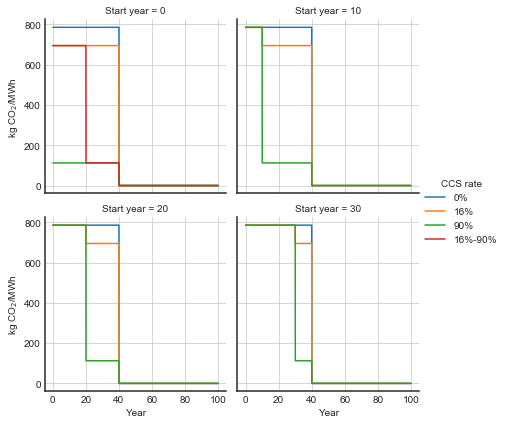

In [18]:
g = sns.FacetGrid(emissions_df[(emissions_df['Fuel']=='Coal')], hue='CCS',
                  col='Start year', hue_order=['0%', '16%', '90%', '16%-90%'],
                  col_wrap=2)
g.map(plt.plot, 'Time', 'CO2').add_legend(title='CCS rate')
g.set_ylabels('kg CO$_2$/MWh')
g.set_xlabels('Year')
# g.set(ylim=(0,None), xlim=(0,None))

file_path = join('../Figures', 'SCPC CO2 emissions.pdf')
plt.savefig(file_path)

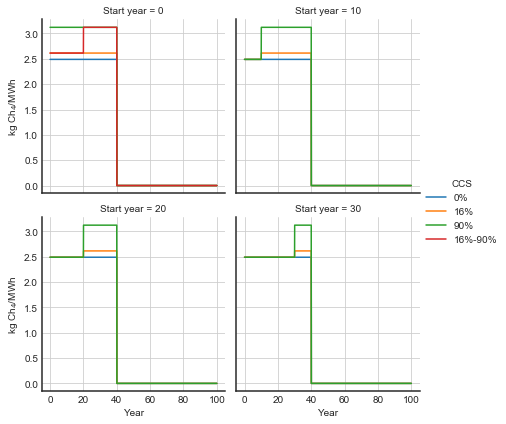

In [20]:
g = sns.FacetGrid(emissions_df[(emissions_df['Fuel']=='Coal')], hue='CCS',
                  col='Start year', hue_order=['0%', '16%', '90%', '16%-90%'],
                  col_wrap=2)
g.map(plt.plot, 'Time', 'CH4')
g.add_legend()
g.set_ylabels('kg Ch$_4$/MWh')
g.set_xlabels('Year')
file_path = os.path.join('../Figures', 'SCPC CH4 emissions.pdf')
plt.savefig(file_path)

#### NGCC

In [21]:
leak_values =['NGCC ' + str(leak) + '%' for leak in range(1,11)]

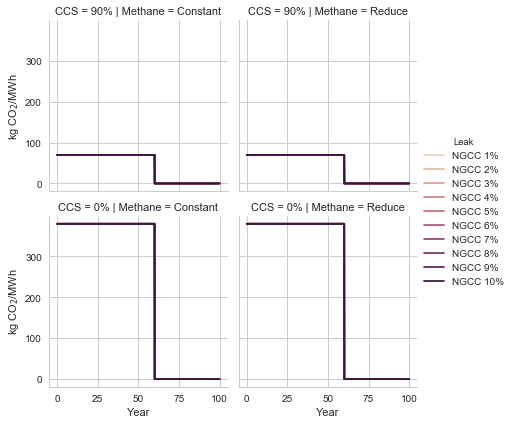

In [22]:
g = sns.FacetGrid(start_emissions[(start_emissions['Fuel']=='NG')], 
                  row='CCS', hue='Leak', col='Methane', 
                  palette=sns.cubehelix_palette(10, 0.2, hue=1),
                  hue_order=leak_values)
g.map(plt.plot, 'Time', 'CO2')
g.set_ylabels('kg CO$_2$/MWh')
g.set_xlabels('Year')
g.add_legend()
file_path = os.path.join('../Figures', 'NGCC start CO2 emissions.pdf')
plt.savefig(file_path)

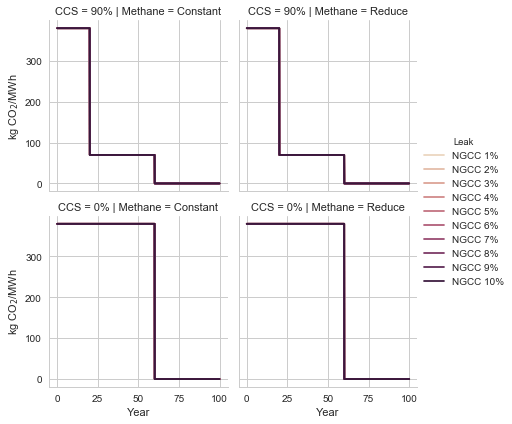

In [23]:
g = sns.FacetGrid(delay_emissions[(delay_emissions['Fuel']=='NG')], row='CCS', 
                  col='Methane', hue='Leak', palette=sns.cubehelix_palette(10, 0.2, hue=1),
                  hue_order=leak_values)
g.map(plt.plot, 'Time', 'CO2')
g.set_ylabels('kg CO$_2$/MWh')
g.set_xlabels('Year')
g.add_legend()
file_path = os.path.join('../Figures', 'NGCC delay CO2 emissions.pdf')
plt.savefig(file_path)

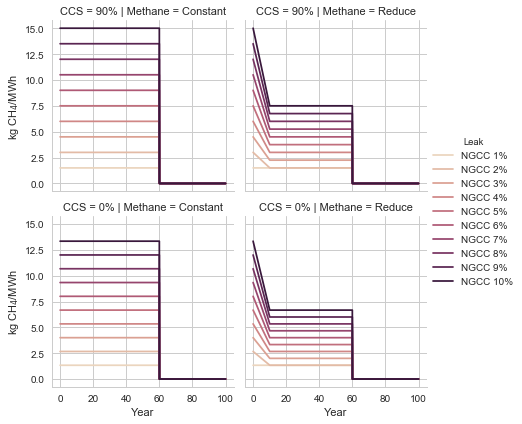

In [24]:
g = sns.FacetGrid(start_emissions[(start_emissions['Fuel']=='NG')], row='CCS', 
                  hue='Leak', col='Methane', palette=sns.cubehelix_palette(10, 0.2, hue=1),
                  hue_order=leak_values)
g.map(plt.plot, 'Time', 'CH4')
g.set_ylabels('kg CH$_4$/MWh')
g.set_xlabels('Year')
g.add_legend()
file_path = os.path.join('../Figures', 'NGCC start CH4 emissions.pdf')
plt.savefig(file_path)

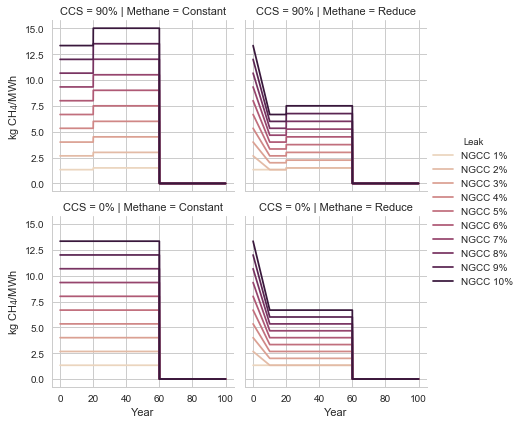

In [25]:
g = sns.FacetGrid(delay_emissions[(delay_emissions['Fuel']=='NG')], row='CCS', 
                  hue='Leak', col='Methane', palette=sns.cubehelix_palette(10, 0.2, hue=1),
                  hue_order=leak_values)
g.map(plt.plot, 'Time', 'CH4')
g.set_ylabels('kg CH$_4$/MWh')
g.set_xlabels('Year')
g.add_legend()
file_path = os.path.join('../Figures', 'NGCC delay CH4 emissions.pdf')
plt.savefig(file_path)

## Export data

In [31]:
emissions_df.dtypes

CO2            object
CH4            object
Leak           object
CCS            object
Fuel           object
Methane        object
Start year     object
Time          float64
dtype: object

In [36]:
path = os.path.join('..', 'Data', 'all emissions.gz')
emissions_df.to_csv(path, index=False, compression='gzip')

In [21]:
export_dict = {'start_emissions' : start_emissions,
               'start_list' : start_list,
               'delay_emissions' : delay_emissions,
               'delay_list' : delay_list}

In [22]:
# pickle with gzip, from http://stackoverflow.com/questions/18474791/decreasing-the-size-of-cpickle-objects
def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol)

In [24]:
export_path = os.path.join('../Data', 'emissions 1-10 percent.pgz')
save_zipped_pickle(export_dict, export_path)

## References

1. NETL. Life Cycle Analysis of Natural Gas Extraction and Power Generation. (National Energy Technology Laboratory, 2014).
2. NETL. Life Cycle Analysis of Natural Gas Extraction and Power Generation. (National Energy Technology Laboratory, 2016).
3. NETL. Cost and Performance Baseline for Fossil Energy Plants Volume 1a: Bituminous Coal (PC) and Natural Gas to Electricity Revision 3. (National Energy Technology Laboratory, 2015).
4. NETL. Power Plant Flexible Model Technical Documentation and User’s Manual. (National Energy Technology Laboratory, 2013).